In [1]:
import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/g/gaddcz/Projects/CPRD/virtual-env-{node_type}'
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
    print(f"Added path '{venv_site_pkgs}' at start of search paths.")
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

!pwd

%load_ext autoreload
%autoreload 2

Added path '/rds/homes/g/gaddcz/Projects/CPRD/virtual-env-icelake/lib/python3.10/site-packages' at start of search paths.
/rds/homes/g/gaddcz/Projects/CPRD/examples/modelling/benchmarks/2_RandomSurvivalForest


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [ ]:
import pytorch_lightning
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import sqlite3
from dataclasses import dataclass
import logging
from CPRD.data.foundational_loader import FoundationalDataModule
from CPRD.src.models.survival.task_heads.causal import SurvStreamGPTForCausalModelling
from pycox.evaluation import EvalSurv

torch.manual_seed(1337)
logging.basicConfig(level=logging.INFO)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"    # if more informative debugging statements are needed
print(f"Using device: {device}.")

In [4]:
# Set config to be equivalent architecture of kaparthy benchmark, however they are not comparable tasks.
@dataclass
class DemoConfig:
    block_size: int = 128        # what is the maximum context length for predictions?
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    bias: bool = True
    attention_type: str = "global"    
    dropout: float = 0.0
    unk_freq_threshold: float = 0.0
    SurvLayer = "Competing-Risk"                                  # "Competing-Risk"
    tokens_for_univariate_regression = None

config = DemoConfig()

@dataclass
class OptConfig:
    batch_size: int = 64
    eval_interval: int = 1
    learning_rate: float = 3e-4
    epochs: int = 100
    
opt = OptConfig()

In [47]:
from CPRD.data.database import queries

# Get a list of patients which fit a reduced set of criterion
PATH_TO_DB = "/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/FoundationModel/preprocessing/processed/cprd.db"
conn = sqlite3.connect(PATH_TO_DB)
cursor = conn.cursor()
# identifiers1 = queries.query_measurement(["bmi", "diastolic_blood_pressure"], cursor)       
identifiers1 = queries.query_diagnosis(["ANXIETY", "DEPRESSION"], cursor)    #   ,  "ANXIETY" "TYPE1DM", "TYPE2DIABETES"
identifiers2 = queries.query_diagnosis(["SUBSTANCEMISUSE"], cursor)     #   ,  "ANXIETY" "TYPE1DM", "TYPE2DIABETES"
all_identifiers = list(set(identifiers1).intersection(identifiers2))    # Turn smaller list into the set
all_identifiers = identifiers1

if False:
    # Lets take only the first N for faster run-time
    N = np.min((len(all_identifiers), 20000))
    print(f"Using N={N} random samples, from the available {len(all_identifiers)}")
    identifiers = random.choices(all_identifiers, k=N)
else:
    print(f"Using all available {len(all_identifiers)} samples")
    identifiers = all_identifiers

# Build 
dm = FoundationalDataModule(identifiers=identifiers,
                            tokenizer="tabular",
                            batch_size=opt.batch_size,
                            max_seq_length=config.block_size,
                            unk_freq_threshold=config.unk_freq_threshold,
                            include_measurements=True,
                            include_diagnoses=True,
                            preprocess_measurements=True
                           )

vocab_size = dm.train_set.tokenizer.vocab_size

print(f"{len(dm.train_set)} training samples")
print(f"{len(dm.val_set)} validation samples")
print(f"{len(dm.test_set)} test samples")
print(f"{vocab_size} vocab elements (including PAD and UNK tokens)")
display(dm.train_set.tokenizer._itos)

INFO:root:Building polars dataset


Using all available 180066 samples


INFO:root:Using measurements
INFO:root:Using test/measurement standardisation method: normalise
INFO:root:Removing measurement and test outliers. Using three deviations from mean as cutoff
INFO:root:Using diagnoses
INFO:root:Dropping samples with no dynamic events
INFO:root:Using tabular tokenizer


115796 training samples
6434 validation samples
6433 test samples
90 vocab elements (including PAD and UNK tokens)


{0: 'PAD',
 1: 'UNK',
 2: 'diastolic_blood_pressure',
 3: 'eosinophil_count',
 4: 'bmi',
 5: 'basophil_count',
 6: 'corrected_serum_calcium_level',
 7: 'DEPRESSION',
 8: 'ANXIETY',
 9: 'serum_level',
 10: 'calculated_LDL_cholesterol_level',
 11: 'ASTHMA_PUSHASTHMA',
 12: 'ATOPICECZEMA',
 13: 'HYPERTENSION',
 14: 'OSTEOARTHRITIS',
 15: 'ALLERGICRHINITISCONJ',
 16: 'ANY_DEAFNESS_HEARING_LOSS',
 17: 'PREVALENT_IBS',
 18: 'aspartate_transam',
 19: 'ALCOHOLMISUSE',
 20: 'ALLCA_NOBCC_VFINAL',
 21: 'TYPE2DIABETES',
 22: 'IHD_NOMI',
 23: 'calcium_adjusted_level',
 24: 'PERIPHERAL_NEUROPATHY',
 25: 'HYPOTHYROIDISM_DRAFT_V1',
 26: 'CKDSTAGE3TO5',
 27: 'COPD',
 28: 'blood_urea',
 29: 'combined_total_vitamin_D2_and_D3_level',
 30: 'SUBSTANCEMISUSE',
 31: 'OSTEOPOROSIS',
 32: 'PSORIASIS',
 33: 'AF',
 34: 'HF',
 35: 'GOUT',
 36: 'ALL_DEMENTIA',
 37: 'hydroxyvitamin3',
 38: 'STROKEUNSPECIFIED',
 39: 'MINFARCTION',
 40: 'hydroxyvitamin2',
 41: 'EPILEPSY',
 42: 'VALVULARDISEASES',
 43: 'POLYCYSTIC_OVAR

In [6]:
# max_length_seen = -1
# for batch in dm.train_dataloader():
#     print(batch["tokens"].shape)
#     if batch["tokens"].shape[1] > max_length_seen:
#         max_length_seen = batch["tokens"].shape[1] 
#     # print(batch["ages"])

# print(max_length_seen)
# print(batch.keys())

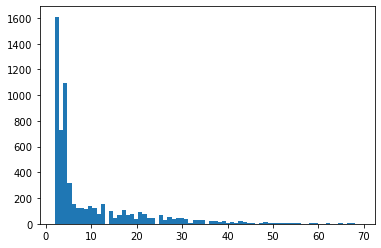

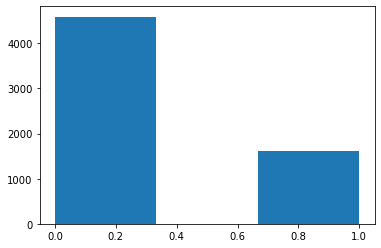

incidence percentage 25.97%


torch.Size([6200, 72])

torch.Size([6200])

torch.Size([6200])

,UNK,SUBSTANCEMISUSE,DEPRESSION,ANXIETY,ALCOHOLMISUSE,ASTHMA_PUSHASTHMA,ATOPICECZEMA,ALLERGICRHINITISCONJ,HYPERTENSION,OSTEOARTHRITIS,...,HAEMOCHROMATOSIS,SYSTEMIC_LUPUS_ERYTHEMATOSUS,PARKINSONS,MS,ADDISON_DISEASE,SJOGRENSSYNDROME,PLASMACELL_NEOPLASM,SICKLE_CELL_DISEASE,SYSTEMIC_SCLEROSIS,DOWNSSYNDROME
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([(False, 1181.), (False, 1036.), (False,   91.), (False, 2991.),
       (False, 1004.)], dtype=[('cens', '?'), ('time', '<f8')])

In [7]:
def make_batch_cross_sectional(batch, vocab_size):
    """
    Wrapper around batches produced by FoundationalDataModule.
    
    Produces a batch which contains 
        * the first N-1 events as a binary vector (e.g. 1, 0, 0, 0, 1... where 1 indicates condition at that index has been diagnosed)
        * the N-th event as a target, given as the index of event (e.g. as k \in {1,2,....})
        * the delta time between the N-1th and N-th event

    event values align with the token indices used in FoundationalDataModule.

    Note: the first covariate is the <UNK> token, even if no UNK tokens exist. We may wish to remove this covariate if not needed.
    """
    _bsz = batch["tokens"].shape[0]    
    delta_ages = batch["ages"][:, 1:] - batch["ages"][:,:-1]

    # print(batch["ages"][-1, :])
    # print(batch["ages"][-1, 1:])
    # print(batch["ages"][-1, :-1])
    # print(delta_ages[-1, :])

    tokens = torch.zeros((_bsz, vocab_size-1))
    target_ages = torch.zeros((_bsz))
    target_ks = torch.zeros((_bsz))
    for _b in range(_bsz):
        tkn_btc = batch["tokens"][_b, :]
        covariates_idx = tkn_btc[torch.nonzero(tkn_btc)]                # the events thats occurred. These are still the integers used in the encodings. Consequently
                                                                        # ... counting begins at 1 as zero was the <PAD> token
        tokens[_b, covariates_idx[:-1, :] - 1] += 1                     # cross-sectional record of first N-1 events that occurred.
                                                                        # ... Subtract 1 to begin indexing at zero (first column = first event token)
        target_ages[_b] = delta_ages[_b, covariates_idx.shape[0]-2]     # time of N-th event
        target_ks[_b] = covariates_idx[-1, :]                           # and value of that N-th event k \in {1,2,....}
                                                                        # ... 0 would be a censored event, but all our events observe something
                                                                        # ... in a competing risk model the events not of interest should be mapped to 0 as censored

    # print(f'tkns: {batch["tokens"][_b, :]}')
    # print(f'ages: {delta_ages[_b, :]}')
    # print(covariates_idx)
    # print(tokens[_b,:])
    # print(target_ages[_b])
    # print(target_ks[_b])
        
    return {"covariates": tokens,
            "t": target_ages,
            "k": target_ks}

# Stack batches for benchmark model
X, yt, yk = [], [], []
for batch in dm.train_dataloader():
    new_batch = make_batch_cross_sectional(batch, vocab_size)
    # print(new_batch)
    X.append(new_batch["covariates"])
    yt.append(new_batch["t"])
    yk.append(new_batch["k"])
X = torch.concat(X, dim=0)
yt = torch.concat(yt, dim=0)
yk = torch.concat(yk, dim=0)
plt.hist(yk,bins=vocab_size); plt.show()

# Convert from competing risk format to a single risk format
target_token = dm.train_set.tokenizer._stoi["SUBSTANCEMISUSE"]
plt.hist(torch.where(yk == target_token, 1, 0), bins=3); plt.show()
yk = torch.where(yk == target_token, True, False).detach().cpu()
print(f"incidence percentage {torch.mean(yk, dtype=torch.float32)*100:.2f}%")

display(X.shape)
display(yt.shape)
display(yk.shape)

Xt = pd.DataFrame(X.detach().cpu().numpy(),  columns=list(dm.train_set.tokenizer._stoi.keys())[1:])
y = np.array([(_yk, _yt) for _yk, _yt in zip(yk.detach().cpu().numpy(), yt.detach().cpu().numpy())],
             dtype=[('cens', 'bool'), ('time', '<f8')])
display(Xt.head())
display(y[:5])

In [8]:
if False:
    X, y = load_gbsg2()
    
    grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
    grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)
    
    X_no_grade = X.drop("tgrade", axis=1)
    Xt = OneHotEncoder().fit_transform(X_no_grade)
    Xt.loc[:, "tgrade"] = grade_num
    
    display(Xt.head())
    print(y.shape)
    print(y[0])
    display(y[:5])

In [9]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [10]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [11]:
rsf.score(X_test, y_test)

0.8733016502825598

In [12]:
cases = [["SUBSTANCEMISUSE"], ["ANXIETY"], ["DEPRESSION"],
         ["SUBSTANCEMISUSE", "ANXIETY"], ["SUBSTANCEMISUSE", "DEPRESSION"], ["ANXIETY", "DEPRESSION"],
         ["SUBSTANCEMISUSE", "ANXIETY", "DEPRESSION"]
        ]

# X_test_sorted = X_test.sort_values(by=["SUBSTANCEMISUSE", "ANXIETY", "DEPRESSION"])
# X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))
X_test_sel = pd.DataFrame(np.zeros((len(cases), len(X_train.columns))), columns=X_train.columns)
for _idx_case, _cases in enumerate(cases):
    for _condition in _cases:
        X_test_sel.iloc[_idx_case][_condition] += 1
        
display(X_test_sel)
display(X_test_sel.sum(axis=1))
# display(X_test)


,UNK,SUBSTANCEMISUSE,DEPRESSION,ANXIETY,ALCOHOLMISUSE,ASTHMA_PUSHASTHMA,ATOPICECZEMA,ALLERGICRHINITISCONJ,HYPERTENSION,OSTEOARTHRITIS,...,HAEMOCHROMATOSIS,SYSTEMIC_LUPUS_ERYTHEMATOSUS,PARKINSONS,MS,ADDISON_DISEASE,SJOGRENSSYNDROME,PLASMACELL_NEOPLASM,SICKLE_CELL_DISEASE,SYSTEMIC_SCLEROSIS,DOWNSSYNDROME
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    1.0
1    1.0
2    1.0
3    2.0
4    2.0
5    2.0
6    3.0
dtype: float64

In [13]:
pd.Series(rsf.predict(X_test_sel))

0     26.627952
1    700.001528
2    825.211279
3     73.164046
4     50.778911
5    865.998791
6     73.107276
dtype: float64

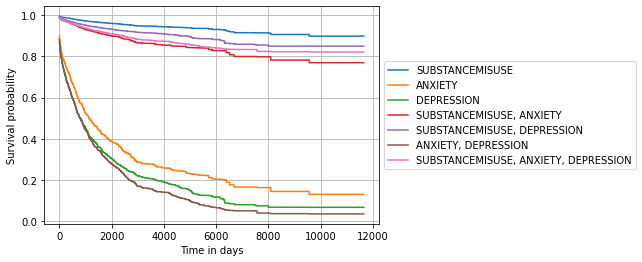

In [14]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    label = ", ".join(cases[i])
    plt.step(rsf.unique_times_, s, where="post", label=label)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

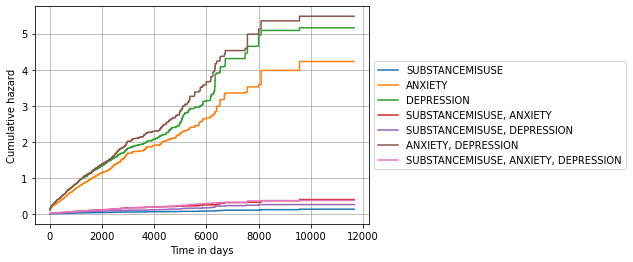

In [15]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    label = ", ".join(cases[i])
    plt.step(rsf.unique_times_, s, where="post", label=label)
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)